# Build Target Model

Here we expand our on target rules to include information about the target site.
We consider four feature classes when building this model:

1. Position within a gene, including sgRNA oriention
2. Protein Domain information: whether a guide targets within an annotated protein domain
3. Sequence conservation
4. Amino acid idenity and physiochemical properties


In [1]:
import pandas as pd
from sklearn.model_selection import StratifiedGroupKFold, train_test_split
from sklearn.base import clone
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score
import joblib
import sglearn
import seaborn as sns
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
from scipy import stats
import optuna
from joblib import Parallel, delayed
from datetime import datetime
import numpy as np

import target_featurization as ft
from core import (get_predictive_performance,
                  plot_pearson_heatmap,
                  plot_pearson_lollipop,
                  get_tidy_cv_df)
from datasets import dataset_list, get_sg_groups_df


In [2]:

def get_fold_predictions(fold, fold_df, model_name, features,
                         aa_seq_df,
                         protein_domain_df,
                         conservation_df,
                         base_model=Pipeline([('imputer', SimpleImputer(strategy='median')),
                                              ('regressor', LGBMRegressor(random_state=7, n_jobs=8))]),
                         aa_width=8, aa_features=None,
                         cons_small_width=2, cons_large_width=32):
    """Get predictions for a given fold

    :param fold: int
    :param fold_df: DataFrame
    :param model_name: str
    :param features: list
    :param aa_seq_df: DataFrame, fed into target featurization
    :param protein_domain_df: DataFrame, fed into target featurization
    :param conservation_df: DataFrame, fed into target featurization
    :param base_model: Pipeline(Imputer, Regressor)
    :param aa_width: int
    :param aa_features: list or None, see featurize_aa_seqs for options. Will default to best options if None
    :param cons_small_width: int
    :param cons_large_width: int
    :return: DataFrame, test predictions
    """
    train_df = fold_df.query('train == True').reset_index(drop=True)
    train_feature_df, train_feature_cols = ft.build_target_feature_df(train_df,
                                                                      features=features,
                                                                      aa_seq_df=aa_seq_df, aa_width=aa_width,
                                                                      aa_features=aa_features,
                                                                      protein_domain_df=protein_domain_df,
                                                                      conservation_df=conservation_df,
                                                                      cons_small_width=cons_small_width,
                                                                      cons_large_width=cons_large_width)
    X_train = train_feature_df[train_feature_cols]
    y_train = train_df['Residual Activity']
    test_df = fold_df.query('train == False').reset_index(drop=True)
    test_feature_df, test_feature_cols = ft.build_target_feature_df(test_df,
                                                                    features=features,
                                                                    aa_seq_df=aa_seq_df, aa_width=aa_width,
                                                                    aa_features=aa_features,
                                                                    protein_domain_df=protein_domain_df,
                                                                    conservation_df=conservation_df,
                                                                    cons_small_width=cons_small_width,
                                                                    cons_large_width=cons_large_width)
    X_test = test_feature_df[test_feature_cols]
    model = clone(base_model)
    model.fit(X_train,  y_train)
    dataset_test_predictions = test_df.copy()
    dataset_test_predictions['prediction'] = model.predict(X_test)
    dataset_test_predictions['model_name'] = model_name
    dataset_test_predictions['fold'] = fold
    return dataset_test_predictions


def lgbm_training_iteration(fold_df, train_index, features,
                            aa_seq_df, protein_domain_df,
                            conservation_df,
                            test_index, base_model):
    """Train lgbm model for optuna iterations

    :param fold_df: DataFrame
    :param train_index: list-like
    :param features: list, features to us
    :param aa_seq_df: DataFrame
    :param protein_domain_df: DataFrame
    :param conservation_df: DataFrame
    :param test_index: list-like
    :param base_model: Pipeline (Imputer, Regressor
    :return: r^2
    """
    train_df = fold_df.iloc[train_index,:].reset_index(drop=True)
    train_feature_df, train_feature_cols = ft.build_target_feature_df(train_df,
                                                                      features=features,
                                                                      aa_seq_df=aa_seq_df,
                                                                      protein_domain_df=protein_domain_df,
                                                                      conservation_df=conservation_df)
    X_train_val = train_feature_df[train_feature_cols] # train and validation data
    y_train_val = train_df['Residual Activity']
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val,
                                                      test_size=0.1, random_state=7)
    model = clone(base_model)
    model.fit(X_train, y_train,
              regressor__early_stopping_rounds=20,
              regressor__eval_set=[(X_val, y_val)],
              regressor__verbose=False)
    test_df = fold_df.iloc[test_index,:].reset_index(drop=True)
    test_feature_df, test_feature_cols = ft.build_target_feature_df(test_df,
                                                                    features=features,
                                                                    aa_seq_df=aa_seq_df,
                                                                    protein_domain_df=protein_domain_df,
                                                                    conservation_df=conservation_df)
    X_test = test_feature_df[test_feature_cols]
    test_predictions = test_df.copy()
    test_predictions['prediction'] = model.predict(X_test)
    r2 = r2_score(test_predictions['Residual Activity'], test_predictions['prediction'])
    return r2


def get_lgbm_objective(fold_df, features, aa_seq_df, protein_domain_df, conservation_df):
    """Get objective function for training a lgbm model

    :param fold_df: DataFrame
    :param features: list
    :param aa_seq_df: DataFrame
    :param protein_domain_df: DataFrame
    :param conservation_df: DataFrame
    :return: obejctive function
    """
    def objective(trial):
        """For training set, get optimal hyperparameters for Pipeline

        :param trial: optuna.trial
        :return: int, pearson correlation with held out test data
        """
        sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=7)
        num_leaves = trial.suggest_int('num_leaves', 8, 256)
        min_child_samples = trial.suggest_int('min_child_samples', 8, 256)
        model = Pipeline([('imputer', SimpleImputer(strategy='median')),
                          ('regressor',
                           LGBMRegressor(random_state=7, n_jobs=1, learning_rate=0.01, n_estimators=5000,
                                         num_leaves=num_leaves,
                                         min_child_samples=min_child_samples))])
        performance = Parallel(n_jobs=5)(delayed(lgbm_training_iteration)
                                         (fold_df, train_index, features,
                                          aa_seq_df, protein_domain_df,
                                          conservation_df,
                                          test_index, model) for
                                         train_index, test_index in
                                         sgkf.split(fold_df, fold_df.dataset, fold_df.target))
        avg_performance = np.mean(performance)
        return avg_performance
    return objective


## Reading Data

In [3]:
train_data_names = pd.read_csv('../data/processed/train_data_names.csv').name.to_list()
protein_domains = pd.read_csv('../data/interim/protein_domains.csv')
aa_seqs = pd.read_csv('../data/interim/aa_seqs.csv')
seq_model = joblib.load('../models/RuleSet3.pkl')

### Rename Database Columns

In [4]:
aa_seqs = aa_seqs.rename({'query': 'Transcript Base'}, axis=1)
protein_domains = protein_domains.rename({'Parent': 'Transcript Base'}, axis=1)

## Loading Datasets

In [5]:
train_data_list = list()
for ds in dataset_list:
    if (ds.name in train_data_names) and ds.endogenous:
        train_data_list.append(ds)


sg_groups_df = get_sg_groups_df(train_data_list)
sg_groups_df = ft.add_target_columns(sg_groups_df)


Context sequences with multiple targets: 0


## Protein Domain Features

In [6]:
domain_model_matrix = ft.get_protein_domain_features(sg_groups_df, protein_domains, sources=None)

/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.


[]

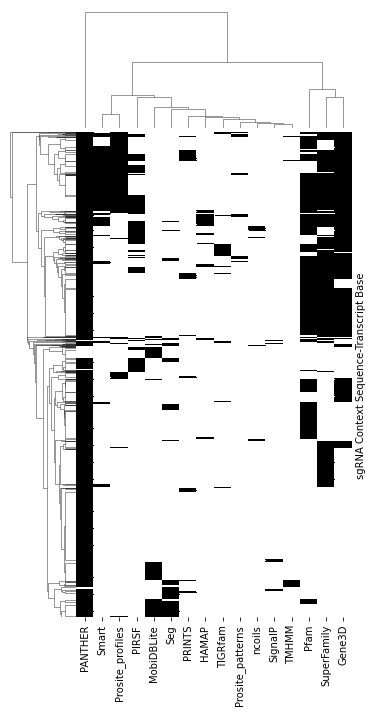

In [7]:
g = sns.clustermap(domain_model_matrix.set_index(['sgRNA Context Sequence', 'Transcript Base']),
                   cmap='binary', cbar_pos=None, metric='hamming')
g.ax_heatmap.get_yaxis().set_ticks([])


In [8]:
long_domain_model_matrix = domain_model_matrix.melt(id_vars=['Transcript Base', 'sgRNA Context Sequence'],
                                                    var_name='source',
                                                    value_name='present')
long_domain_model_matrix = long_domain_model_matrix[long_domain_model_matrix['present'] == 1]
(long_domain_model_matrix[['Transcript Base', 'source']].value_counts()
 .reset_index()['source'].value_counts())

PANTHER             46
Pfam                44
Gene3D              41
SuperFamily         35
Seg                 31
Prosite_patterns    30
MobiDBLite          22
Smart               18
Prosite_profiles    15
HAMAP               11
PIRSF               11
TMHMM                9
SignalP              8
PRINTS               7
TIGRfam              7
ncoils               5
Name: source, dtype: int64

## Conservation of Protein Domains

We'll merge conservation scores with the protein domain matrix to understand how protein domains are conserved

In [9]:
transcript_bases = list(sg_groups_df['Transcript Base']
                        .unique())
conservation_df = (pd.read_parquet('../data/interim/conservation.parquet',
                                   filters=[[('Transcript Base', 'in', transcript_bases)]])
                   .reset_index(drop=True))
conservation_df['ranked_conservation'] = (conservation_df.groupby('Transcript Base')
                                          ['conservation']
                                          .rank(pct=True))


In [10]:
conservation_aa_i = conservation_df.copy()
conservation_aa_i['aa_i'] = (conservation_aa_i['target position'] - 1) // 3 + 1
conservation_aa_i['loc_id'] = conservation_aa_i['Transcript Base'] + conservation_aa_i['aa_i'].astype(str)
# Filter sifts
conservation_domains = (conservation_aa_i.merge(protein_domains[protein_domains['type'] != 'sifts'],
                                                how='inner',
                                                on='Transcript Base'))
conservation_domains = (conservation_domains[conservation_domains['aa_i']
                        .between(conservation_domains['start'], conservation_domains['end'])])
conservation_non_domains = conservation_aa_i[~conservation_aa_i['loc_id'].isin(conservation_domains['loc_id'])]
conservation_cat = (pd.concat([conservation_domains, conservation_non_domains])
                    .reset_index(drop=True))
conservation_cat['type'] = conservation_cat['type'].fillna('None')
conservation_cat_summary = (conservation_cat.groupby(['type', 'genome'])
                            .agg(median_conservation = ('conservation', 'median'),
                                 n_obs = ('conservation', 'count'))
                            .reset_index()
                            .sort_values('median_conservation'))
conservation_cat_summary['name'] = (conservation_cat_summary['type'] +
                                    '(n=' +
                                    conservation_cat_summary['n_obs'].astype(str) +
                                    ')')
hg_conservation_cat_summary = conservation_cat_summary[conservation_cat_summary['genome'].str.contains('hg')]
mm_conservation_cat_summary = conservation_cat_summary[conservation_cat_summary['genome'].str.contains('mm')]
hg_conservation_cat = conservation_cat.merge(hg_conservation_cat_summary, how='inner')
hg_conservation_cat['name'] = pd.Categorical(hg_conservation_cat['name'],
                                             categories=hg_conservation_cat_summary['name'])
mm_conservation_cat = conservation_cat.merge(mm_conservation_cat_summary, how='inner')
mm_conservation_cat['name'] = pd.Categorical(mm_conservation_cat['name'],
                                             categories=mm_conservation_cat_summary['name'])

Text(0.5, 1.0, 'Human Training Data\nDomain Conservation')

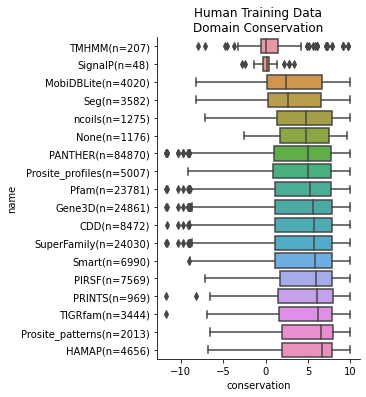

In [11]:
sns.catplot(data=hg_conservation_cat, y='name', x='conservation', kind='box')
plt.title('Human Training Data\nDomain Conservation')

Text(0.5, 1.0, 'Mouse Training Data\nDomain Conservation')

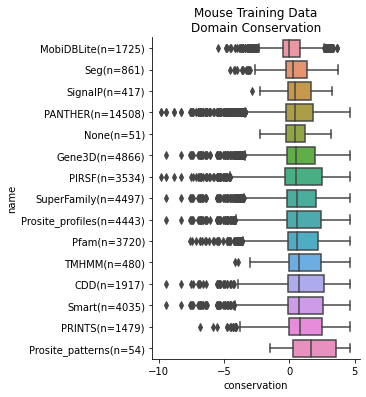

In [12]:
sns.catplot(data=mm_conservation_cat, y='name', x='conservation', kind='box')
plt.title('Mouse Training Data\nDomain Conservation')

## Calculating Residuals

In [13]:
sg_df_residuals = sg_groups_df.copy()
sg_df_residuals['sgRNA Activity'] = (sg_df_residuals.groupby('dataset')
                                     ['sgRNA Activity']
                                     .rank(pct=True))
seq_X = sglearn.featurize_guides(sg_df_residuals['sgRNA Context Sequence'])
sg_df_residuals['Rule Set 3'] = seq_model.predict(seq_X)
(sg_df_residuals.groupby('dataset')
 .apply(lambda df: stats.pearsonr(df['Rule Set 3'], df['sgRNA Activity'])))

dataset
Doench2014_human     (0.7747588150394162, 6.327280047472541e-200)
Doench2014_mouse    (0.7221909327038771, 4.8841724249361805e-189)
Doench2016                        (0.6639725734142461, 3.06e-322)
Wang2014              (0.740204397054155, 4.967999241925921e-178)
dtype: object

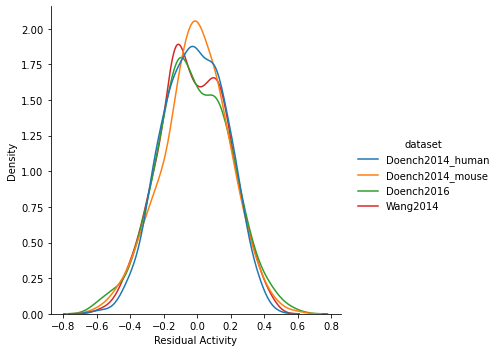

In [14]:
sg_df_residuals['Residual Activity'] = sg_df_residuals['sgRNA Activity'] - sg_df_residuals['Rule Set 3']
sns.displot(data=sg_df_residuals, x='Residual Activity', hue='dataset',
            kind='kde', common_norm=False)

## Cross Validation iterator

We'll use [StratifiedGroupKFold](https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.StratifiedGroupKFold.html#sklearn.model_selection.StratifiedGroupKFold)

Every dataset appears as both a training and testing
dataset in every fold, except Doench2014_human Doench2014_mouse, which have fewer than 5 genes

In [15]:
tidy_cv_df = get_tidy_cv_df(sg_df_residuals, random_state=1)
cv_train_data_counts = (tidy_cv_df[['cv', 'train', 'dataset']].value_counts()
                        .reset_index(name='n'))
(cv_train_data_counts[['cv', 'dataset']]
 .value_counts()
 .reset_index(name='n')
 .sort_values(['n', 'cv', 'dataset']))

,cv,dataset,n
19,0,Doench2014_human,1
18,1,Doench2014_human,1
17,2,Doench2014_human,1
16,2,Doench2014_mouse,1
1,0,Doench2014_mouse,2
15,0,Doench2016,2
14,0,Wang2014,2
13,1,Doench2014_mouse,2
12,1,Doench2016,2
11,1,Wang2014,2


- Training sizes vary from 5,258 - 4,253 sgRNAs
- Testing sizes vary from 1,469 - 464 sgRNAs

In [16]:
(tidy_cv_df[['cv','train']].value_counts()
 .reset_index(name='n')
 .sort_values(['cv', 'train']))

,cv,train,n
9,0,False,464
0,0,True,5258
6,1,False,1441
3,1,True,4281
8,2,False,1093
1,2,True,4629
5,3,False,1469
4,3,True,4253
7,4,False,1255
2,4,True,4467


As expected each gene target (gene) only appears in one set in each fold

In [17]:
(tidy_cv_df[['cv','train', 'target']].value_counts()
 .reset_index(name='n')
 [['cv', 'target']].value_counts()  # will show up twice if train == False and True
 .reset_index(name='train_test_sum')
 .groupby('cv')
 .agg({'train_test_sum': ['max']}))

,train_test_sum
,max
cv,
0,1
1,1
2,1
3,1
4,1


## Testing Feature Sets

### Amino Acid Width

In [18]:
aa_width_prediction_list = []
aa_widths = [2, 4, 8, 16, 32]
feature_sets = {'AA core ': ['Pos. Ind. 1mer', 'Hydrophobicity', 'Aromaticity',
                             'Isoelectric Point',
                             'Secondary Structure'],
                'AA expanded ': ['Pos. Ind. 1mer', 'Pos. Ind. 2mer',
                                 'Pos. Dep. 1mer', 'Hydrophobicity', 'Aromaticity',
                                 'Isoelectric Point',
                                 'Secondary Structure']}
for width in aa_widths:
    print(width)
    for aa_name, aa_features in feature_sets.items():
        print(aa_name)
        for fold, df in tidy_cv_df.groupby('cv'):
            print('Fold: ' + str(fold))
            predictions = get_fold_predictions(fold, df, model_name=aa_name + str(width),
                                               features=['aa'],
                                               aa_seq_df=aa_seqs,
                                               protein_domain_df=protein_domains,
                                               conservation_df=conservation_df,
                                               aa_width=width, aa_features=aa_features)
            aa_width_prediction_list.append(predictions)
        print('\n')
    print('\n')

aa_width_predictive_performance, aa_width_agg_performance = get_predictive_performance(aa_width_prediction_list,
                                                                                       'Residual Activity')

2
AA core 
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4


AA expanded 
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4




4
AA core 
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4


AA expanded 
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4




8
AA core 
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4


AA expanded 
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4




16
AA core 
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4


AA expanded 
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4




32
AA core 
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4


AA expanded 
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4






We'll use the core feature set with a width of 8 as our default for Amino Acid featurization,
because of its smaller standard deviation and it's a smaller feature set

In [19]:
aa_width_agg_performance

,model_name,mean_pearson,std_pearson,median_pearson
5,AA expanded 16,0.139326,0.126947,0.164898
4,AA core 8,0.138851,0.088333,0.142859
0,AA core 16,0.135611,0.173130,0.161232
7,AA expanded 32,0.134132,0.139195,0.146084
2,AA core 32,0.127277,0.160753,0.100677
9,AA expanded 8,0.123862,0.098569,0.118428
3,AA core 4,0.103118,0.070096,0.113957
8,AA expanded 4,0.081990,0.085799,0.097776
1,AA core 2,0.073011,0.068647,0.084579
6,AA expanded 2,0.058164,0.097596,0.060468


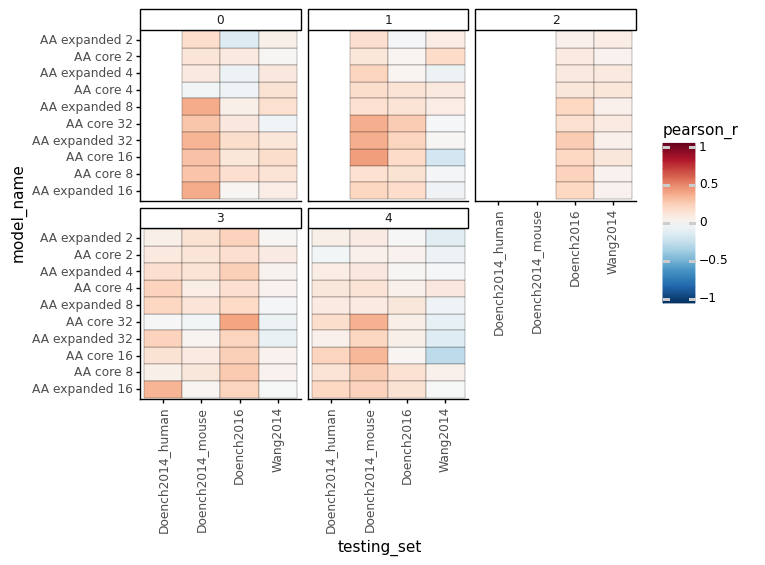

<ggplot: (8766910012326)>

In [20]:
plot_pearson_heatmap(aa_width_predictive_performance)

### Conservation Width

In [21]:
cons_width_prediction_list = []
cons_small_widths = [2, 4, 8]
cons_large_widths = [16, 32, 64]
for small_width in cons_small_widths:
    print('Small: ' + str(small_width))
    for large_width in cons_large_widths:
        print('Large: ' + str(large_width))
        for fold, df in tidy_cv_df.groupby('cv'):
            print('Fold: ' + str(fold))
            predictions = get_fold_predictions(fold, df, model_name='cons ' + str(small_width) +  ', ' +
                                                                    str(large_width),
                                               features=['conservation'],
                                               aa_seq_df=aa_seqs,
                                               protein_domain_df=protein_domains,
                                               conservation_df=conservation_df,
                                               cons_small_width=small_width,
                                               cons_large_width=large_width)
            cons_width_prediction_list.append(predictions)
        print('\n')
    print('\n')

cons_width_predictive_performance, cons_width_agg_performance = get_predictive_performance(cons_width_prediction_list,
                                                                                           'Residual Activity')

Small: 2
Large: 16
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4


Large: 32
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4


Large: 64
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4




Small: 4
Large: 16
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4


Large: 32
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4


Large: 64
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4




Small: 8
Large: 16
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4


Large: 32
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4


Large: 64
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4






It looks like a small width of 2 and a large width of 32 is optimal for conservation

In [22]:
cons_width_agg_performance

,model_name,mean_pearson,std_pearson,median_pearson
1,"cons 2, 32",0.065648,0.118560,0.077228
0,"cons 2, 16",0.056232,0.099990,0.059343
7,"cons 8, 32",0.043436,0.137237,0.066272
8,"cons 8, 64",0.040279,0.135325,0.011211
6,"cons 8, 16",0.039075,0.118380,0.023835
5,"cons 4, 64",0.037510,0.144255,0.030288
2,"cons 2, 64",0.035280,0.127863,0.018686
4,"cons 4, 32",0.023476,0.133078,0.015333
3,"cons 4, 16",0.016731,0.112682,0.023339


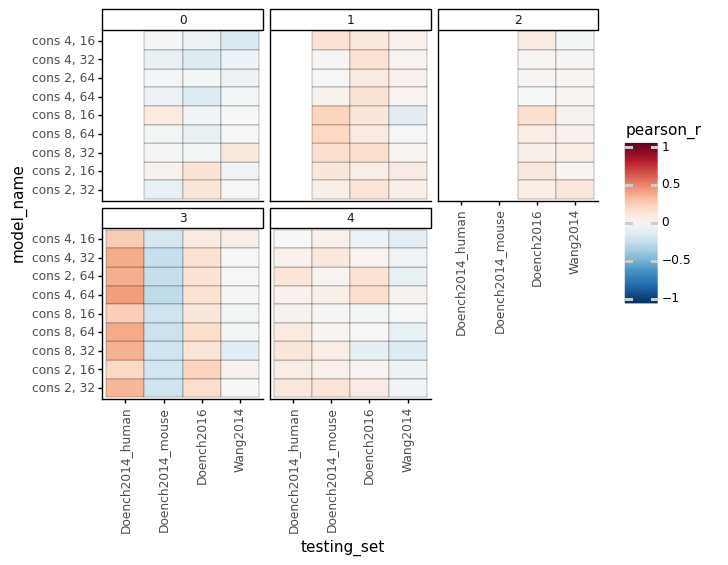

<ggplot: (8766900583114)>

In [23]:
plot_pearson_heatmap(cons_width_predictive_performance)

### Single Feature Sets

In [24]:
single_prediction_list = []
features = ['position', 'aa', 'domain', 'conservation']
for feature in features:
    print(feature)
    for fold, df in tidy_cv_df.groupby('cv'):
        print('Fold: ' + str(fold))
        predictions = get_fold_predictions(fold, df, model_name=feature,
                                           features=[feature],
                                           aa_seq_df=aa_seqs,
                                           protein_domain_df=protein_domains,
                                           conservation_df=conservation_df)
        single_prediction_list.append(predictions)
    print('\n')

single_predictive_performance, single_agg_performance = get_predictive_performance(single_prediction_list,
                                                                                   'Residual Activity')


position
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4


aa
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4


domain
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4


conservation
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4




All features are able to positively predict the residual activity of sgRNAs

In [25]:
single_agg_performance

,model_name,mean_pearson,std_pearson,median_pearson
2,domain,0.189147,0.188298,0.178348
3,position,0.173096,0.169692,0.126095
0,aa,0.138851,0.088333,0.142859
1,conservation,0.065648,0.118560,0.077228


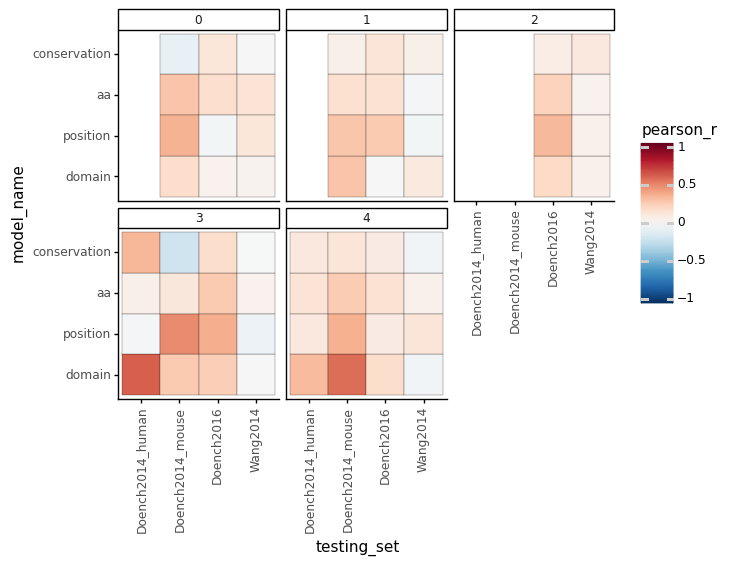

<ggplot: (8766879733800)>

In [26]:
plot_pearson_heatmap(single_predictive_performance)

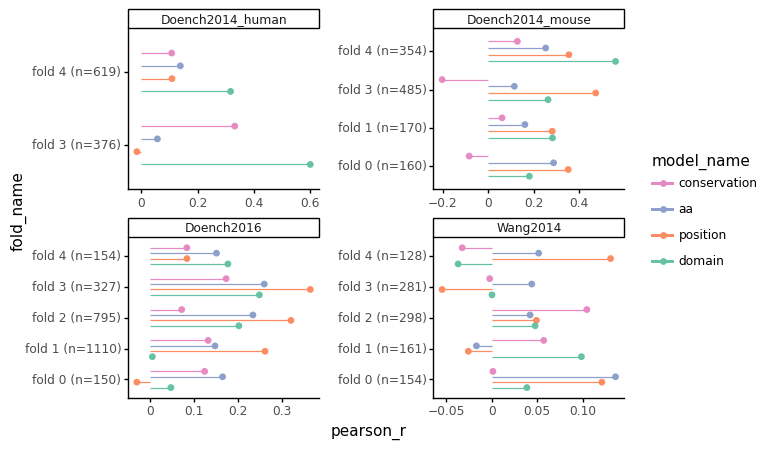

<ggplot: (8766889069294)>

In [27]:
plot_pearson_lollipop(single_predictive_performance)

### Complete Feature Set

All features together are better than any one alone.

In [28]:
complete_feature_list = []
features = ['position', 'aa', 'domain', 'conservation']
for fold, df in tidy_cv_df.groupby('cv'):
    print('Fold: ' + str(fold))
    predictions = get_fold_predictions(fold, df, model_name='All',
                                       features=features,
                                       aa_seq_df=aa_seqs,
                                       protein_domain_df=protein_domains,
                                       conservation_df=conservation_df)
    complete_feature_list.append(predictions)

complete_predictive_performance, complete_agg_performance = get_predictive_performance(complete_feature_list +
                                                                                       single_prediction_list,
                                                                                       'Residual Activity')

Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4


In [29]:
complete_agg_performance

,model_name,mean_pearson,std_pearson,median_pearson
0,All,0.245154,0.164946,0.270687
3,domain,0.189147,0.188298,0.178348
4,position,0.173096,0.169692,0.126095
1,aa,0.138851,0.088333,0.142859
2,conservation,0.065648,0.118560,0.077228


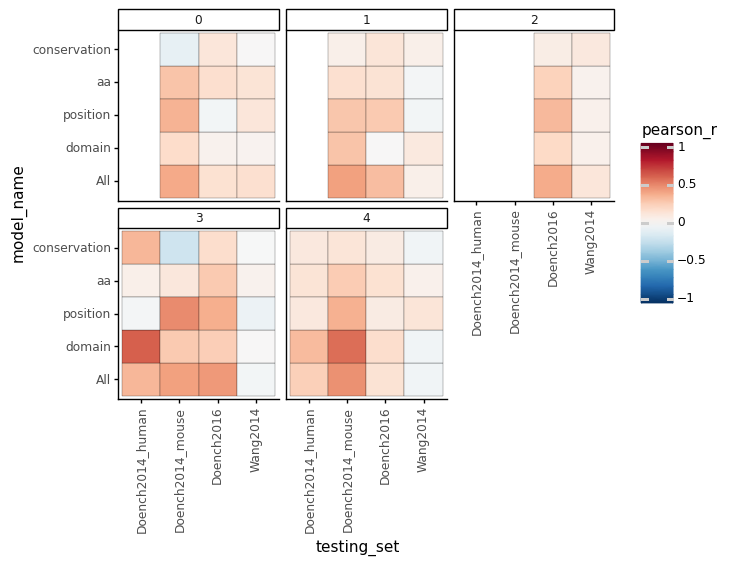

<ggplot: (8766880193073)>

In [30]:
plot_pearson_heatmap(complete_predictive_performance)

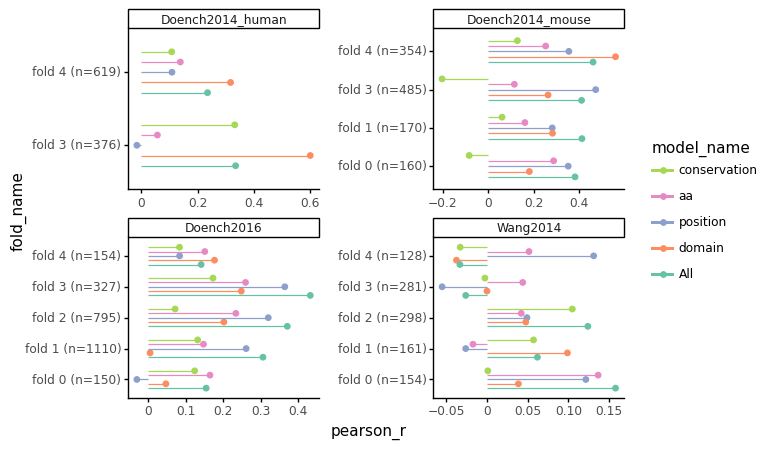

<ggplot: (8766880251124)>

In [31]:
plot_pearson_lollipop(complete_predictive_performance)

### Leave One Set Out

All features are necessary to achieve this result

In [32]:
leave_one_prediction_list = []
features = ['position', 'aa', 'domain', 'conservation']
for feature in features:
    print(feature)
    curr_features = features.copy()
    curr_features.remove(feature)
    for fold, df in tidy_cv_df.groupby('cv'):
        print('Fold: ' + str(fold))
        predictions = get_fold_predictions(fold, df, model_name='No ' + feature,
                                           features=curr_features,
                                           aa_seq_df=aa_seqs,
                                           protein_domain_df=protein_domains,
                                           conservation_df=conservation_df)
        leave_one_prediction_list.append(predictions)
    print('\n')

leave_one_predictive_performance, leave_one_agg_performance = get_predictive_performance(
    leave_one_prediction_list + complete_feature_list, 'Residual Activity')

position
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4


aa
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4


domain
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4


conservation
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4




In [33]:
leave_one_agg_performance

,model_name,mean_pearson,std_pearson,median_pearson
0,All,0.245154,0.164946,0.270687
2,No conservation,0.228212,0.164415,0.215120
1,No aa,0.221818,0.206168,0.245347
3,No domain,0.220874,0.166579,0.184105
4,No position,0.198195,0.183347,0.165881


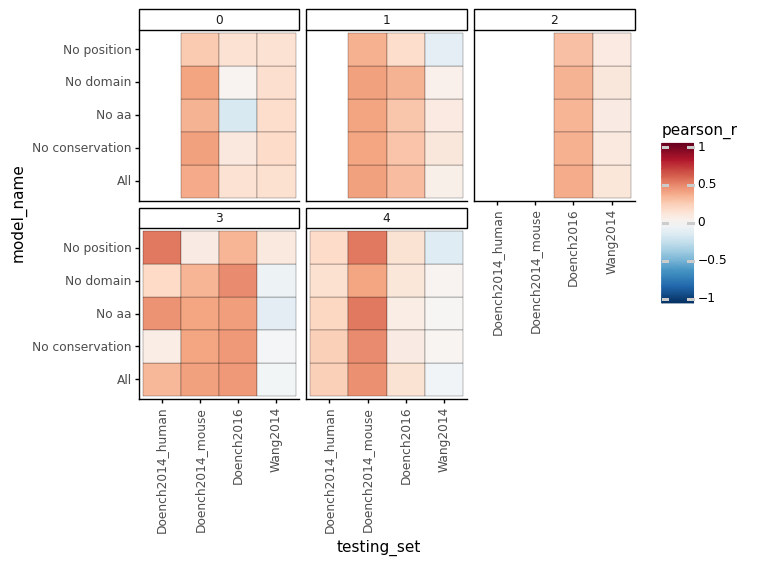

<ggplot: (8766912166753)>

In [34]:
plot_pearson_heatmap(leave_one_predictive_performance)

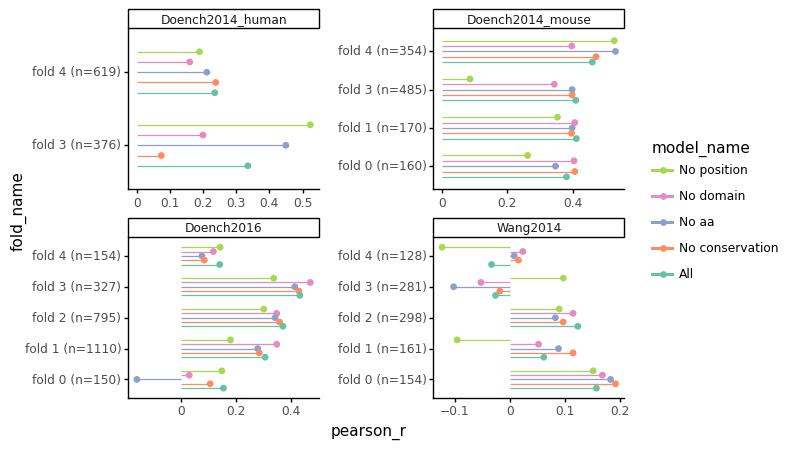

<ggplot: (8766912281528)>

In [35]:
plot_pearson_lollipop(leave_one_predictive_performance)

## Hyperparameter Tuning

We'll use optuna to tune hyperparameters for the model

In [36]:
n_trials = 50
model_name = 'ALL + TPE ' + str(n_trials)

In [37]:
tpe_prediction_list = []

for fold, fold_df in tidy_cv_df.groupby('cv'):
    print('Fold: ' + str(fold))
    fold_train_data = fold_df.query('train == True').reset_index(drop=True)
    study = optuna.create_study(direction='maximize',
                                sampler=optuna.samplers.TPESampler(seed=7)) # maximize r^2
    objective = get_lgbm_objective(fold_train_data, features=features,
                                   aa_seq_df=aa_seqs, protein_domain_df=protein_domains,
                                   conservation_df=conservation_df)
    start_time = datetime.now()
    study.optimize(objective, n_trials=n_trials)
    end_time = datetime.now()
    difference = end_time - start_time
    print("Number of finished trials: {}".format(len(study.trials)))
    print("Training Time: " + str(difference))
    print("Best trial:")
    trial = study.best_trial
    print("  Value: {}".format(trial.value))
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
    # Using optimal parameters, retrain model with full dataset
    train_df = fold_train_data.copy()
    train_feature_df, train_feature_cols = ft.build_target_feature_df(train_df,
                                                                      features=features,
                                                                      aa_seq_df=aa_seqs,
                                                                      protein_domain_df=protein_domains,
                                                                      conservation_df=conservation_df)
    X_train_val = train_feature_df[train_feature_cols] # train and validation data
    y_train_val = train_df['Residual Activity']
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val,
                                                      test_size=0.1, random_state=7)
    model = Pipeline([('imputer', SimpleImputer(strategy='median')),
                      ('regressor',
                       LGBMRegressor(random_state=7, n_jobs=8, learning_rate=0.01, n_estimators=5000,
                                     **trial.params))])
    model.fit(X_train, y_train,
              regressor__early_stopping_rounds=20,
              regressor__eval_set=[(X_val, y_val)],
              regressor__verbose=1000)
    fold_test_data = fold_df.query('train == False').reset_index(drop=True)
    test_feature_df, test_feature_cols = ft.build_target_feature_df(fold_test_data,
                                                                    features=features,
                                                                    aa_seq_df=aa_seqs,
                                                                    protein_domain_df=protein_domains,
                                                                    conservation_df=conservation_df)
    X_test = test_feature_df[test_feature_cols]
    test_predictions = fold_test_data.copy()
    test_predictions['prediction'] = model.predict(X_test)
    test_predictions['model_name'] = model_name
    test_predictions['fold'] = fold
    tpe_prediction_list.append(test_predictions)


[I 2021-05-16 17:38:40,374] A new study created in memory with name: no-name-f22ce73f-ff6c-40df-aeee-4b0841eaf915
[I 2021-05-16 17:38:46,116] Trial 0 finished with value: 0.08595087751989376 and parameters: {'num_leaves': 27, 'min_child_samples': 202}. Best is trial 0 with value: 0.08595087751989376.
[I 2021-05-16 17:38:48,619] Trial 1 finished with value: 0.08738210552071565 and parameters: {'num_leaves': 117, 'min_child_samples': 188}. Best is trial 1 with value: 0.08738210552071565.
[I 2021-05-16 17:38:51,069] Trial 2 finished with value: 0.09469910002454858 and parameters: {'num_leaves': 251, 'min_child_samples': 142}. Best is trial 2 with value: 0.09469910002454858.
[I 2021-05-16 17:38:53,855] Trial 3 finished with value: 0.07221683574408651 and parameters: {'num_leaves': 132, 'min_child_samples': 25}. Best is trial 2 with value: 0.09469910002454858.
[I 2021-05-16 17:38:56,450] Trial 4 finished with value: 0.09044386427930258 and parameters: {'num_leaves': 74, 'min_child_samples':

Fold: 0
Number of finished trials: 50
Training Time: 0:02:16.064490
Best trial:
  Value: 0.09770432595111
  Params: 
    num_leaves: 13
    min_child_samples: 148
Training until validation scores don't improve for 20 rounds
[1000]	valid_0's l2: 0.0335124
Early stopping, best iteration is:
[997]	valid_0's l2: 0.0335059
Fold: 1
Number of finished trials: 50
Training Time: 0:01:54.002482
Best trial:
  Value: 0.06067376012277319
  Params: 
    num_leaves: 35
    min_child_samples: 235
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[620]	valid_0's l2: 0.0348206
Fold: 2
Number of finished trials: 50
Training Time: 0:02:02.215385
Best trial:
  Value: 0.09915670120411493
  Params: 
    num_leaves: 53
    min_child_samples: 111
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[352]	valid_0's l2: 0.033772
Fold: 3
Number of finished trials: 50
Training Time: 0:02:08.700677
Best trial:
  Value: 0.045263

Tuning hyperparameters improves performance quite a bit

In [38]:
tpe_predictive_performance, tpe_agg_performance = get_predictive_performance(
    complete_feature_list + tpe_prediction_list, 'Residual Activity')

In [39]:
tpe_agg_performance

,model_name,mean_pearson,std_pearson,median_pearson
0,ALL + TPE 50,0.270298,0.188572,0.312380
1,All,0.245154,0.164946,0.270687


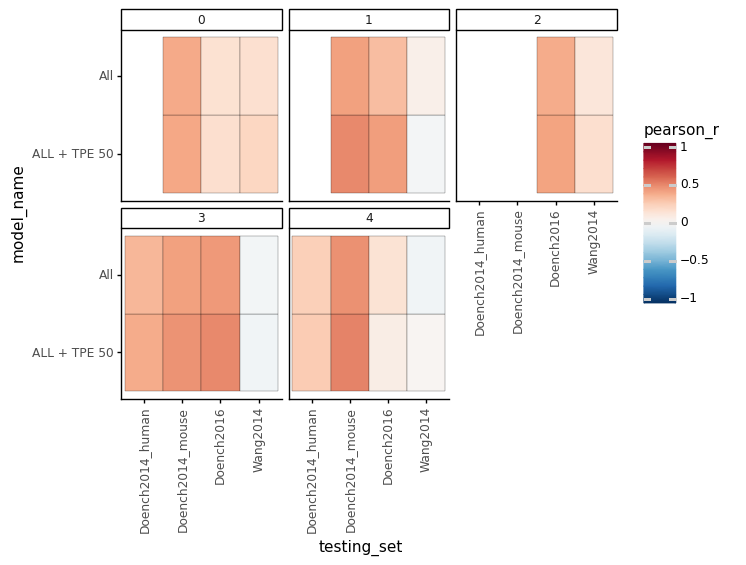

<ggplot: (8766880265439)>

In [40]:
plot_pearson_heatmap(tpe_predictive_performance)

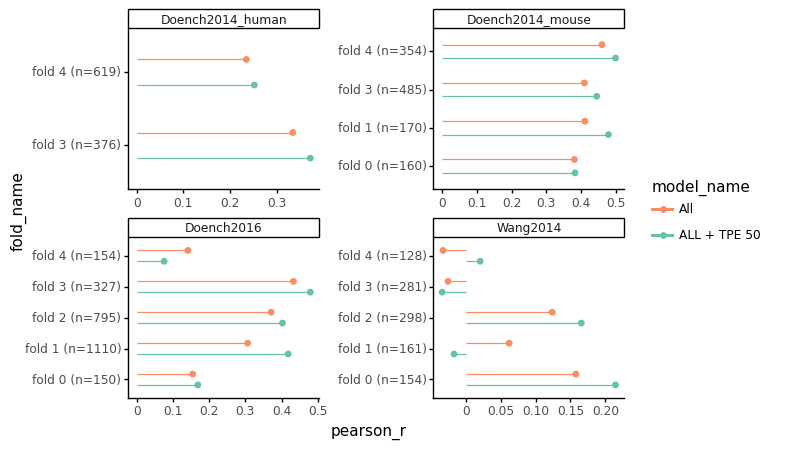

<ggplot: (8766895050774)>

In [41]:
plot_pearson_lollipop(tpe_predictive_performance)